# A showcase of the different functionalities of the framework

## Workflow

- **Step 1: Gather the Test Inputs**
  - The test session with all the pictures and coordinates
  - The global coordinates of the device
- **Step 2: check for relevant Reference data**
  - use the global coordinates to find all the reference data that is geo-referenced close enough (GPS precision)
- **Step 3: 2D Check**
  - Compare all the test images against all the reference images
  - Find which session has the highest match rate
  - Find which Image has the highest match rate
  - Calculate the transformation between the two images
  - calculate the inverse transformation to give the test data a Reference global position
- **Step 4: 3D Check**
  - Compare the test mesh against relevant point clouds
  - Compare the test mesh against BIM models
  - Perform a CCP for the final alignment
- **Step 5: Choosing final Position**
  - Use the different results from all the methods to come to a best position
  - Send the Position and rotation back to the device

## Session Functionality
A session contains all the data from the folder: the images, meshes and their locations. It also contains the geo-reference position and rotation

### Importing and Selecting Sessions
Sessions can either be directly imported from a path, or be selected from a parent directory based on the distance to the reference point.

In [ ]:
import numpy as np
import session

# you can import all the close enough sessions from a parent directory 
sessionsFolderLocation = "/Volumes/GeomaticsProjects1/Projects/2025-03 Project FWO SB Jelle/7.Data/21-11 Testbuilding Campus/RAW Data"
referencePoint = np.array([0,0,0])
maxDistance = 10
sessions = session.find_close_sessions(sessionsFolderLocation, referencePoint, maxDistance)

In [ ]:
import session
# you can also import a single session from the directory
sessionDirectory = "/Volumes/GeomaticsProjects1/Projects/2025-03 Project FWO SB Jelle/7.Data/21-11 Testbuilding Campus/RAW Data/Hololens/session-2021-11-25 16-09-47"
singleSession = session.Session().from_path(sessionDirectory)
print (singleSession.__dict__)

### Bounding Area
Each session has a bounding area to determine if the reference position is close enough to the data

In [ ]:
boundingBox = singleSession.get_bounding_box()
boundingRadius = singleSession.get_bounding_radius()

print("The axis aligned bounding box (2x3 array) min and max corner points ", boundingBox)
print ("The bounding radius from the reference Center:", boundingRadius)

### Image transforms
The image transform contains the Image file, and it's transform in session space

In [ ]:
# an image transform is stored in 
image1 = singleSession.imageTransforms[0]
print(image1.__dict__)

#### The Image
The image is stored as an openCV color image.

In [ ]:
from matplotlib import pyplot as plt
import cv2

cv2Image = image1.get_cv2_image()

plt.rcParams['figure.dpi'] = 300
plt.imshow(cv2.cvtColor(cv2Image, cv2.COLOR_BGR2RGB))
plt.title('cv2 Color Image')
plt.show()

##### The Image Camera
An image contains it's camera matrix based on the image resolution and vertical fov

In [ ]:
print("The 3x3 Camera matrix: \n", image1.get_camera_matrix())

print("The 3x4 camera projection matrix: \n", image1.get_projection_matrix())

### The Geometries

In [ ]:
import positioning3D as pos3D
import session

sessionDirectory = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 16-17-19"
singleSession = session.Session().from_path(sessionDirectory)
#print(singleSession.geometries)
pos3D.show_geometries(singleSession.geometries, True)

## Positioning 2D Functionality
All the different methods and functions to calculate the relative position of a Session using 2D data

### Comparing Images
2 images can be compared against each other to find the corresponding matches and quality of the match.

In [ ]:
import session
from matplotlib import pyplot as plt
import cv2

#import 2 images from a session
sessionDirectory = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 11-12-17"
singleSession = session.Session().from_path(sessionDirectory)
image1 = singleSession.imageTransforms[0]
image2 = singleSession.imageTransforms[1]
image3 = singleSession.imageTransforms[2]


#Find the matches between the 2 images
import compareImage as ci

match = ci.ImageMatch(image1, image2)
match.find_matches()
matchImage = match.draw_image_matches()
plt.rcParams['figure.dpi'] = 300
plt.imshow(cv2.cvtColor(matchImage, cv2.COLOR_BGR2RGB))
plt.title('cv2 Color Image')
plt.show()

### Comparing Sessions
You can also compare 2 sessions to each other, depending

In [ ]:
session2Directory = "/Volumes/GeomaticsProjects1/Projects/2025-03 Project FWO SB Jelle/7.Data/21-11 Testbuilding Campus/RAW Data/Hololens/session-2021-11-25 16-17-19"
Session2 = session.Session().from_path(session2Directory)

import positioning2D as pos2D

bestResults = pos2D.compare_session(singleSession, Session2)

print(bestResults.__dict__)

### Calculating the Transformation matrix
The transformation between 2 matched images can be determined using the Essential matrix.

In [ ]:
import compareImage as ci

match = ci.ImageMatch(image1, image2)
match.find_matches()
match.calculate_transformation_matrix()
matchImage = match.draw_image_inliers()
plt.rcParams['figure.dpi'] = 300
plt.imshow(cv2.cvtColor(matchImage, cv2.COLOR_BGR2RGB))
plt.title('cv2 Color Image')
plt.show()

### Triangulating the Camera Position
When the transformation matrix is calculated, the next step is to determine the camera pose.
Because the Essential matrix is correct up to a scale factor, that scale factor needs to be determined first.

#### Minimum distance between known points
The first method requires 2 reference images and 1 test image. Since the location of the reference image is known and the direction of the test image is also determined, The location of the test image can be calculated by finding the minimal distance between the 2 estimated positions.

In [ ]:
import transform

matchScore2, E2, imMatches2 = ci.compare_image(image1, image2)
matchScore3, E3, imMatches3 = ci.compare_image(image1, image3)

newPos, rot1, pos1, pos2, scale = transform.triangulate_session(image2, image3, E2, E3)

print("Estimated position:", newPos)
print("Actual position:", image1.pos)

#### Incremental Matching
Since the location of the reference images is known, we can calculate the feature scaling by matching 2 reference images. By then matching the test image to one of the matched images, the scale is already known.

In [1]:
import session

#import 2 images from a session
sessionDirectory = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 11-12-17"
singleSession = session.Session().from_path(sessionDirectory)
image1 = singleSession.imageTransforms[0]
image2 = singleSession.imageTransforms[1]
image1.fov *=2
image2.fov *= 2

In [2]:
#Find the matches between the 2 images
import compareImage as ci

match = ci.ImageMatch(image1, image2)
match.find_matches()
match.calculate_transformation_matrix()
projectionMatrices = match.get_projectionMatrices()
#correctKeypoints = match.get_keypoints_from_indices()
#print("F: \n", match.fundamentalMatrix)
print("E: \n", match.essentialMatrix)
#print("projectionMatrix: \n", projectionMatrices)

E: 
 [[ 0.07240791 -3.24554048  0.03033243]
 [ 3.06152483 -0.11444028  0.35282008]
 [ 0.07813278 -2.16557236  0.02366805]]


In [9]:
# recover the pose
import cv2
import numpy as np

retval, E, R, t, mask = cv2.recoverPose(points1= match.testInliers,
                                        points2= match.refInliers, 
                                        cameraMatrix1= image1.get_camera_matrix(),
                                        distCoeffs1= np.zeros((4,1)),
                                        cameraMatrix2= image2.get_camera_matrix(), 
                                        distCoeffs2= np.zeros((1,4)))

#print(retval, E, R, t, mask)
print("E: \n", E, "\nR:\n", R, "\nt:\n", t)

cam1 = image1.get_camera_matrix() @ np.hstack((np.eye(3), np.zeros((3,1))))
cam2 = image2.get_camera_matrix() @ np.hstack((R, t))

E: 
 [[-0.0081434   0.04295655  0.04619843]
 [ 0.06996593  0.01985425 -0.70187424]
 [-0.05736807  0.70329125  0.01129471]] 
R:
 [[ 0.98672982  0.01299249  0.16185008]
 [-0.0175118   0.99949469  0.02652753]
 [-0.16142364 -0.02900979  0.98645874]] 
t:
 [[-0.99594591]
 [-0.06454644]
 [ 0.06265387]]


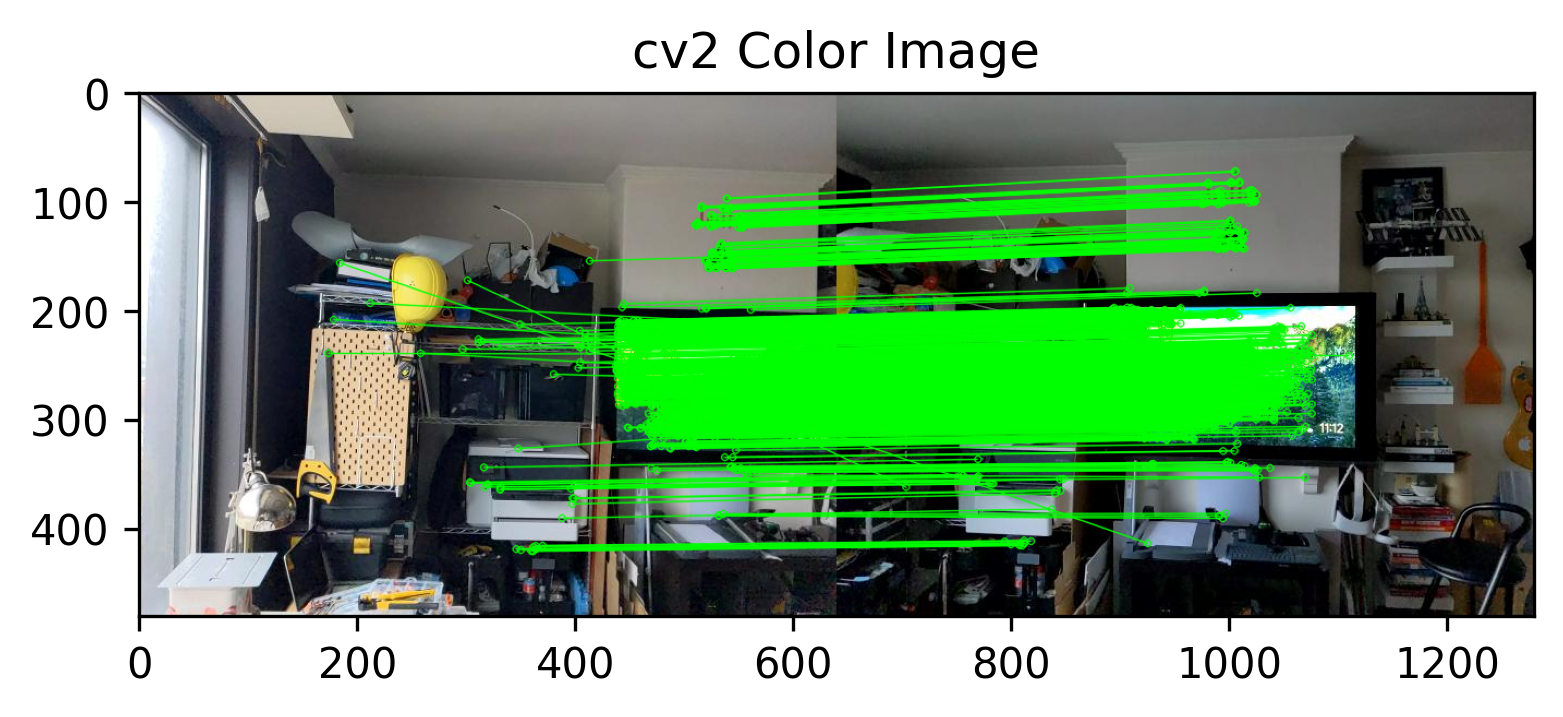

In [3]:
from matplotlib import pyplot as plt
import cv2

matchImage = match.draw_image_inliers()
plt.rcParams['figure.dpi'] = 300
plt.imshow(cv2.cvtColor(matchImage, cv2.COLOR_BGR2RGB))
plt.title('cv2 Color Image')
plt.show()

In [11]:
import positioning3D as pos3D
import open3d as o3d
import numpy as np
import cv2
import transform
testPoints = match.testInliers.T
refPoints = match.refInliers.T
#print(testPoints)

#points3d = cv2.triangulatePoints(projectionMatrices[0], projectionMatrices[2], testPoints, refPoints)
#points3d = cv2.triangulatePoints(image1.get_projection_matrix(), image2.get_projection_matrix(), testPoints, refPoints)
points3d = cv2.triangulatePoints(cam1, cam2,testPoints,refPoints)
points3d = points3d /points3d[3]
finalPoints = np.array(points3d[:3]).T
ret, rvecs, tvecs, more = cv2.solvePnPRansac(points3d[:3].T, refPoints.T,image2.get_camera_matrix(),np.zeros((1,4)))
print("rotation: \n",cv2.Rodrigues(rvecs)[0]," \nTranslation:\n", tvecs)
ret, rvecs, tvecs, more = cv2.solvePnPRansac(points3d[:3].T, testPoints.T,image1.get_camera_matrix(),np.zeros((1,4)))
print("rotation: \n",cv2.Rodrigues(rvecs)[0]," \nTranslation:\n", tvecs)

#print(ret, cv2.Rodrigues(rvecs), tvecs, more)
#cameraPunt = points3d[0].T
#print(cameraPunt[0])
#print(points3d)

#print(finalPoints.T)

cam1 = pos3D.create_3d_camera(scale=0.2)
R1, R2, t1, t2 = transform.check_pose(match.essentialMatrix)
cvTranslation = np.array(- R1.T @ t2)
cvRotation = R1.T
print("R: \n", cvRotation,"\n t: \n", cvTranslation)
cam2 = pos3D.create_3d_camera(cvTranslation,cvRotation , 0.2)
cam2 = pos3D.create_3d_camera(-R.T @t,R.T , 0.2)
cam2_pnp = pos3D.create_3d_camera(tvecs,cv2.Rodrigues(rvecs)[0] , 0.2)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(finalPoints)
#pos3D.show_geometries([image1.get_camera_geometry(), image2.get_camera_geometry(), pcd])
pos3D.show_geometries([pcd, cam1, cam2, cam2_pnp])


rotation: 
 [[-0.66996251 -0.02289216 -0.7420419 ]
 [-0.00802574 -0.99924273  0.03807301]
 [-0.74235155  0.03146292  0.66927144]]  
Translation:
 [[ 0.57837276]
 [-0.00680419]
 [-0.70387061]]
rotation: 
 [[-0.90961732 -0.37072766  0.18750287]
 [ 0.35357307 -0.92778774 -0.11914693]
 [ 0.21813393 -0.04208215  0.97501112]]  
Translation:
 [[ 0.28903652]
 [-0.03563488]
 [-0.64459691]]
R: 
 [[-7.63125214e-01 -8.60210109e-04 -6.46250081e-01]
 [ 1.61405486e-03 -9.99998532e-01 -5.74881341e-04]
 [-6.46248638e-01 -1.48178953e-03  7.63125482e-01]] 
 t: 
 [[-0.11423443]
 [ 0.00673592]
 [ 0.99343099]]


#### Using the 3D scene
The session data might also contain 3D data, like a mesh or point cloud. They are also localized, so once the features are calculated for an image, a ray can be cast from a point to determine the global scale.

In [ ]:
import positioning3D



## Positioning 3D Functionality
Using mesh data to calculate the transformations, the pipeline uses open3D as the main framework for importing, displaying and matching geometry

### Importing meshes and point clouds


In [ ]:
import positioning3D as pos3D
import open3d as o3d

meshPath = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/mesh-2021-11-25 16-16-01.obj"
mesh = pos3D.import_mesh(meshPath)
pos3D.show_geometries([mesh])

In [ ]:
import positioning3D as pos3D

pcdPath = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/S003-SW-002.ply"
pcd = pos3D.import_point_cloud(pcdPath)

pos3D.show_geometries([pcd])

#### Converting and Downsampling
Meshes have to be converted to point clouds to extract features

In [ ]:
meshPath = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/positioning/images/ref/mesh-2021-11-25 16-16-01.obj"
mesh = pos3D.import_mesh(meshPath)
nrOfPoints = 10000
superSampleFactor = 2
pcd = pos3D.to_pcd(mesh, nrOfPoints, superSampleFactor)

### Aligning Point clouds
2 point clouds can be aligned using a FPFH 3D feature matching algorithm.

In [ ]:
import positioning3D as pos3D
import copy

pcd1 = pos3D.import_point_cloud("/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/pcd1.pcd")
#pcd2 = pos3D.import_point_cloud("/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/pcd2.pcd")
pcd2 = pos3D.import_point_cloud("/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/S003-SW-002.ply")

transformation = pos3D.get_pcd_transformation(pcd1, pcd2, 0.1)
print("This is the estimated transformation: \n", transformation)
movedPcd = copy.deepcopy(pcd1)
movedPcd.transform(transformation)
pos3D.show_geometries([pcd1,movedPcd, pcd2])

## Global Alignment
Once a number of estimated transformations are determined, you can compare them to find the best one

## Full example
This a a workflow example going over all the steps

In [ ]:
import numpy as np
import session

referencePoint = np.array([0,0,0])
maxDistance = 10

testSessionDir = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 16-17-19"
refSessionDir = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 16-09-47"
testSession = session.Session().from_path(testSessionDir)
referenceSession = session.Session().from_path(refSessionDir)
closeEnoughSessions = [referenceSession]




In [ ]:
#2D estimation
import positioning2D as pos2D
import transform

ImageTransformations = pos2D.get_2D_transformation(testSession, closeEnoughSessions)

for transformation in ImageTransformations:
    print("These are the estimated transformations:")
    E2 = transformation[0].transMatrix
    E3 = transformation[1].transMatrix
    image2 = transformation[0].refImage
    image3 = transformation[1].refImage
    newPos, rot1, pos1, pos2, scale = transform.triangulate_session(image2, image3, E2, E3)

    print("Estimated position:", newPos)
    print("Actual position:", transformation[0].testImage.pos)

In [ ]:
#3D estimation
import positioning3D as pos3D

MeshTransformation = pos3D.get_3D_transformation(testSession, closeEnoughSessions, 0.1)

In [ ]:

import copy

for transformations in MeshTransformation:
    print("here are the estimated transformations:")
    for i, element in enumerate(transformations):
        print(element)
        transMesh = copy.deepcopy(testSession.geometries[0])
        transMesh.transform(element)
        pos3D.show_geometries([transMesh, closeEnoughSessions[0].geometries[i]])

In [ ]:
transMesh = copy.deepcopy(testSession.geometries[0]).transform(element)
pos3D.show_geometries([transMesh, closeEnoughSessions[0].geometries[0]])

In [ ]:
import positioning3D as pos3D
import numpy as np
import copy

meshPath = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 16-17-19/mesh-2021-11-25 16-17-19.obj"
mesh = pos3D.import_mesh(meshPath)
nrOfPoints = 100000
superSampleFactor = 1
pcdTest = pos3D.to_pcd(mesh, nrOfPoints, superSampleFactor)

meshPath = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/session-2021-11-25 16-09-47/mesh-2021-11-25 16-16-01.obj"
mesh = pos3D.import_mesh(meshPath)
nrOfPoints = 100000
superSampleFactor = 1
pcdRef = pos3D.to_pcd(mesh, nrOfPoints, superSampleFactor)

#pcdRef = pos3D.import_point_cloud("/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/ref/S003-SW-002.ply")

transformation = pos3D.get_pcd_transformation(pcdTest, pcdRef, 0.1)
print("This is the estimated transformation: \n", transformation)
movedPcd = copy.deepcopy(pcdTest)
movedPcd.transform(transformation)
pos3D.show_geometries([pcdTest,movedPcd, pcdRef],True)

## Kerk Example

In [ ]:
import open3d
import cv2
import session
from matplotlib import pyplot as plt
import numpy as np
import compareImage as ci
from transform import ImageTransform
import positioning3D as pos3D
import transform
import open3d as o3d

     

cam1_rot = [-0.4816, -0.7658, 0.4259, -0.7635, 0.1282, -0.6329, 0.43, -0.6300,-0.6465]
cam1_pos = [3.3354, 8.6431, 2.1599]
cam2_rot = [-0.4824, -0.7647, 0.4271, -0.762, 0.1271, -0.6339, 0.4304, -0.6317, -0.6447]
cam2_pos = [4.2553, 9.7217, 5.3615]

image1 = ImageTransform()
image1.path = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/kerk/DJI_0017.JPG"
image1.set_transformation_matrix(cam1_pos, cam1_rot)
image1.fov = 105

image2 = ImageTransform()
image2.path = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/kerk/DJI_0018.JPG"
image2.set_transformation_matrix(cam2_pos, cam2_rot)
image2.fov = 105

In [ ]:
match = ci.ImageMatch(image1, image2)
match.find_matches()
match.calculate_transformation_matrix()
projectionMatrices = match.get_projectionMatrices()
#correctKeypoints = match.get_keypoints_from_indices()
#print("F: \n", match.fundamentalMatrix)
print("E: \n", match.essentialMatrix)
#print("projectionMatrix: \n", projectionMatrices)

In [ ]:
matchImage = match.draw_image_inliers()
plt.rcParams['figure.dpi'] = 300
plt.imshow(cv2.cvtColor(matchImage, cv2.COLOR_BGR2RGB))
plt.title('cv2 Color Image')
plt.show()

In [ ]:
testPoints = match.testInliers.T
refPoints = match.refInliers.T
#print(testPoints)

points3d = cv2.triangulatePoints(projectionMatrices[0], projectionMatrices[1], testPoints, refPoints)
points3d /= points3d[3]
finalPoints = np.array(points3d[:3]).T
#print(finalPoints)

ret, rvecs, tvecs, more = cv2.solvePnPRansac(points3d[:3].T, testPoints.T,image1.get_camera_matrix(),np.zeros((1,4)))

cam1 = pos3D.create_3d_camera(scale=0.2)
R1, R2, t1, t2 = transform.check_pose(match.essentialMatrix)
cvTranslation = np.array(- R1.T @ t1)
cvRotation = R1.T
print("R: \n", cvRotation,"\n t: \n", cvTranslation)
cam2 = pos3D.create_3d_camera(cvTranslation,cvRotation , 0.2)
#cam2 = pos3D.create_3d_camera(np.array([0,-1,0]), R1, 0.2)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(finalPoints)
#pos3D.show_geometries([image1.get_camera_geometry(), image2.get_camera_geometry(), pcd])
pos3D.show_geometries([pcd, cam1, cam2])

In [ ]:
#scaling the scene

realTranslation = image2.pos - image1.pos
realDirection = realTranslation / np.linalg.norm(realTranslation)

realLocalTranslation = image1.get_rotation_matrix().T @ realTranslation
realLocalDirection = realLocalTranslation / np.linalg.norm(realLocalTranslation)
print("Rotationmatrix: \n", image1.get_rotation_matrix())
print("local z axis = \n", image1.get_rotation_matrix() @ np.array([0,0,1]))
print("Real translation(lambert): \n", realTranslation, "\n with direction:", realDirection)
print("Real local translation(lambert): \n", realLocalTranslation, "\n with direction:", realLocalDirection)
print("CV translation(Y down): \n", cvTranslation.T, "\n with direction:", cvTranslation.T / np.linalg.norm(cvTranslation.T))


In [ ]:
# adding the 3rd image

cam3_rot = [-0.4729, -0.7733, 0.4222, -0.8479, 0.2692, -0.4566, 0.2394, -0.5739, -0.7830]
cam3_pos = [4.7772, 8.8708, 13.0912]

image3 = ImageTransform()
image3.path = "/Volumes/Data drive/Documents/Doctoraat Local/PythonDataAlignment/src/positioning/images/kerk/DJI_0024.JPG"
image3.set_transformation_matrix(cam3_pos, cam3_rot)
image3.fov = 105